# Modelo Preditivo CARF

## O que é o CARF?

O **CARF** (Conselho Administrativo de Recursos Fiscais) é um órgão colegiado vinculado ao Ministério da Fazenda no Brasil, responsável por julgar, em segunda instância administrativa, os recursos de contribuintes em processos relacionados a tributos federais e contribuições previdenciárias. Ele atua como uma instância de julgamento administrativo, permitindo que contribuintes e a Receita Federal discutam questões tributárias antes de recorrerem ao Poder Judiciário.

### Objetivos do CARF

1. **Resolução de Conflitos Tributários**: O CARF busca solucionar disputas entre contribuintes e a administração tributária de forma técnica e imparcial.
2. **Garantia de Defesa**: Oferece aos contribuintes a oportunidade de apresentar recursos administrativos, garantindo o contraditório e a ampla defesa.
3. **Redução de Litígios Judiciais**: Ao resolver questões tributárias na esfera administrativa, o CARF contribui para a diminuição de processos no Poder Judiciário.

### Estrutura e Funcionamento

O CARF é composto por conselheiros representantes da Fazenda Nacional e dos contribuintes, que são indicados por entidades de classe. Os julgamentos são realizados em turmas, câmaras ou seções especializadas, dependendo da complexidade e do valor envolvido no processo.

### Importância

O CARF desempenha um papel fundamental no sistema tributário brasileiro, promovendo segurança jurídica e eficiência na resolução de conflitos fiscais. Ele é especialmente relevante para empresas e pessoas físicas que desejam discutir autuações fiscais ou interpretações da legislação tributária sem recorrer imediatamente ao Judiciário.

## Entendimento do Negócio (Business Understanding)

`Compreensão dos objetivos e requisitos do projeto do ponto de vista do negócio. Define-se o problema que se quer resolver e os objetivos da análise.`

**Objetivo Primário:** Prever a probabilidade de uma dívida ser ajuizada com base em características do devedor e da dívida.

**Objetivo Secundário:**  Entender quais fatores impactam a situação das dívidas, como o valor consolidado ou o tipo de crédito. Entender as causas mais comuns para uma dívida ser extinta ou suspensa.

Quando falamos sobre como o CARF (Conselho Administrativo de Recursos Fiscais) lida com a judicialização de suas decisões, estamos tratando da possibilidade de que as partes envolvidas (contribuintes ou a Fazenda Nacional) contestem as decisões do CARF no Poder Judiciário, caso não concordem com o julgamento administrativo. O CARF é uma instância administrativa e suas decisões, embora vinculativas para a administração tributária, podem ser desafiadas judicialmente.

Quando uma ação é ajuizada, o CARF enfrenta desafios operacionais e administrativos que podem afetar sua eficiência e imagem. O impacto mais significativo é indireto, no que diz respeito ao aumento de processos judiciais, ao consumo de recursos internos e à necessidade de responder às demandas do Judiciário.

## Entendimento dos Dados (Data Understanding)

`Coleta inicial dos dados, familiarização com eles, identificação de problemas de qualidade, e geração de hipóteses iniciais.`


### Dados Abertos

* **FGTS:** Refere-se a débitos de empregadores com o fundo de garantia.
* **PREV (Previdenciário):** Débitos de contribuições previdenciárias.
* **SIDA:** Conjunto de dados do sistema unificado da administração federal, com dados detalhados sobre devedores e sua situação perante a União.

Layout dos arquivos:

➜ FGTS PREV e SIDA
| Campo                     | Descrição                                                                 |
|---------------------------|---------------------------------------------------------------------------|
| CPF_CNPJ                  | CPF ou CNPJ do devedor inscrito na dívida ativa.                         |
| TIPO_PESSOA               | Indica se o devedor é pessoa física (F) ou jurídica (J).                 |
| TIPO_DEVEDOR              | Categoria do devedor: contribuinte individual, empresa, órgão público etc. |
| NOME_DEVEDOR              | Nome ou razão social do devedor.                                         |
| UF_DEVEDOR                | Unidade da Federação (estado) do devedor.                               |
| UNIDADE_RESPONSAVEL       | Unidade da PGFN responsável pela inscrição da dívida.                   |
| NUMERO_INSCRICAO          | Número único da inscrição da dívida ativa.                              |
| TIPO_SITUACAO_INSCRICAO   | Tipo da situação da inscrição: ativa, suspensa, extinta etc.            |
| SITUACAO_INSCRICAO        | Descrição detalhada da situação atual da dívida.                        |
| TIPO_CREDITO              | Tipo de crédito tributário ou não tributário (ex: FGTS, Multas).        |
| DATA_INSCRICAO            | Data da inscrição na dívida ativa.                                      |
| INDICADOR_AJUIZADO        | Indica se a dívida foi ajuizada: 'S' ou 'N'.                            |
| VALOR_CONSOLIDADO         | Valor total da dívida com acréscimos legais.                            |

➜ FGTS
| Campo                  | Descrição                                           |
|------------------------|---------------------------------------------------|
| ENTIDADE_RESPONSAVEL   | Entidade que gerou a inscrição do débito FGTS.    |
| UNIDADE_INSCRICAO      | Unidade/agência que realizou a inscrição do débito FGTS. |



**ideias:**
UF_DEVEDOR: tentar análise geográfica, indicando que alguns estados têm mais devedores. baixar dados do IBGE
UNIDADE_RESPONSAVEL: tentar analisar a carga de dívidas por unidade da PGFN.
SITUACAO_INSCRICAO: será que o status da dívida e como isso impacta a cobrança ou ajuizamento.
TIPO_CREDITO: tentar ver risco associado a diferentes tipos de crédito.

Tentar juntar com CNAE:

In [81]:
# Imports 

import sys
import os

import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from modules.utils import (
        find_zip_files_by_pattern,
        read_zip_csvs_as_df,
        dataframe_info,
        extract_origem_from_filename
    )

### Exploratory

In [9]:
f = os.path.join(project_root,'dados','Cnaes.zip')
df_cnae = read_zip_csvs_as_df(f, encoding='latin1', verbose=True)

📂 Reading: F.K03200$Z.D50307.CNAECSV


In [4]:
zip_files = find_zip_files_by_pattern(directory=f"{project_root}/dados/", pattern='FGTS.zip')
all_dfs = []

for f in zip_files:
    print(f"Processando arquivo: {f}")
    df = read_zip_csvs_as_df(f, encoding='latin1', verbose=False)
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)

Processando arquivo: /home/nicolas/github/unb/ppca_mdm/dados/2020T2_Dados_abertos_FGTS.zip
Processando arquivo: /home/nicolas/github/unb/ppca_mdm/dados/2020T1_Dados_abertos_FGTS.zip


In [5]:
dataframe_info(final_df)


DataFrame Information:

Shape: (882198, 16)

Columns: ['CPF_CNPJ', 'TIPO_PESSOA', 'TIPO_DEVEDOR', 'NOME_DEVEDOR', 'UF_UNIDADE_RESPONSAVEL', 'UNIDADE_RESPONSAVEL', 'ENTIDADE_RESPONSAVEL', 'UNIDADE_INSCRICAO', 'NUMERO_INSCRICAO', 'TIPO_SITUACAO_INSCRICAO', 'SITUACAO_INSCRICAO', 'RECEITA_PRINCIPAL', 'DATA_INSCRICAO', 'INDICADOR_AJUIZADO', 'VALOR_CONSOLIDADO', '__source_file__']

Data Types:
CPF_CNPJ                    object
TIPO_PESSOA                 object
TIPO_DEVEDOR                object
NOME_DEVEDOR                object
UF_UNIDADE_RESPONSAVEL      object
UNIDADE_RESPONSAVEL         object
ENTIDADE_RESPONSAVEL        object
UNIDADE_INSCRICAO           object
NUMERO_INSCRICAO            object
TIPO_SITUACAO_INSCRICAO     object
SITUACAO_INSCRICAO          object
RECEITA_PRINCIPAL           object
DATA_INSCRICAO              object
INDICADOR_AJUIZADO          object
VALOR_CONSOLIDADO          float64
__source_file__             object
dtype: object

Missing Values:
CPF_CNPJ         

In [68]:
final_df['CPF_CNPJ'] = (
    final_df['CPF_CNPJ']
    .astype(str)
    .str.replace(r'\D', '', regex=True)
    .where(final_df['CPF_CNPJ'].notna())
)
final_df["ANOMES"] = final_df["__source_file__"].str.extract(r'(\d{6})')
final_df["ORIGEM"] = final_df["__source_file__"].apply(extract_origem_from_filename)




In [7]:
cnpj_counts = final_df['CPF_CNPJ'].value_counts()
duplicate_cnpjs = cnpj_counts[cnpj_counts > 1]
print(f"\nCPF_CNPJs duplicados:")
print(duplicate_cnpjs)

duplicate_rows = final_df[final_df['CPF_CNPJ'].isin(duplicate_cnpjs.index)]




CPF_CNPJs duplicados:
CPF_CNPJ
30477954000150    109
61575775000180    108
60477056000163     94
96653894000198     90
92219070000153     86
                 ... 
26925503000161      2
92635838000170      2
42407429000148      2
02795365000185      2
06266303000137      2
Name: count, Length: 241704, dtype: int64


In [8]:
duplicate_rows.loc[duplicate_rows['CPF_CNPJ'] == '26925503000161']

,CPF_CNPJ,TIPO_PESSOA,TIPO_DEVEDOR,NOME_DEVEDOR,UF_UNIDADE_RESPONSAVEL,UNIDADE_RESPONSAVEL,ENTIDADE_RESPONSAVEL,UNIDADE_INSCRICAO,NUMERO_INSCRICAO,TIPO_SITUACAO_INSCRICAO,SITUACAO_INSCRICAO,RECEITA_PRINCIPAL,DATA_INSCRICAO,INDICADOR_AJUIZADO,VALOR_CONSOLIDADO,__source_file__,ANOMES,ORIGEM
236634,26925503000161,Pessoa jurídica,Principal,J C IND E COMERCIO DE MATERIAIS ESPORTIVOS LTDA,NaN,Não se Aplica,CAIXA,GOIAS,FGGO199900108,Em cobrança,AJUIZADA,Contribuições FGTS,25/02/1999,SIM,10729.25,arquivo_lai_FGTS_NA_202006.csv,202006,FGTS
698236,26925503000161,Pessoa jurídica,Principal,J C IND E COMERCIO DE MATERIAIS ESPORTIVOS LTDA,NaN,Não se Aplica,CAIXA,GOIAS,FGGO199900108,Em cobrança,AJUIZADA,Contribuições FGTS,25/02/1999,SIM,10653.48,arquivo_lai_FGTS_NA_202002.csv,202002,FGTS


In [9]:
count = final_df['NUMERO_INSCRICAO'].value_counts()
duplicates = count[count > 1]
print(duplicates)

duplicate_rows = final_df[final_df['NUMERO_INSCRICAO'].isin(duplicates.index)]


NUMERO_INSCRICAO
FGTO201400143    2
FGTO201500125    2
FGTO201600378    2
FGTO200800023    2
FGTO201900063    2
                ..
FGAC201000057    2
FGAC201000046    2
FGAC201700422    2
FGAC201100024    2
FGAC201500072    2
Name: count, Length: 436896, dtype: int64


In [10]:
duplicate_rows.loc[duplicate_rows['NUMERO_INSCRICAO'] == 'FGTO201500125']

,CPF_CNPJ,TIPO_PESSOA,TIPO_DEVEDOR,NOME_DEVEDOR,UF_UNIDADE_RESPONSAVEL,UNIDADE_RESPONSAVEL,ENTIDADE_RESPONSAVEL,UNIDADE_INSCRICAO,NUMERO_INSCRICAO,TIPO_SITUACAO_INSCRICAO,SITUACAO_INSCRICAO,RECEITA_PRINCIPAL,DATA_INSCRICAO,INDICADOR_AJUIZADO,VALOR_CONSOLIDADO,__source_file__,ANOMES,ORIGEM
440886,10922861000180,Pessoa jurídica,Principal,TEIXEIRA & PEREIRA LTDA,TO,TOCANTINS,PGFN,TOCANTINS,FGTO201500125,Em cobrança,AJUIZADA,Contribuições FGTS,20/08/2015,SIM,8629.79,arquivo_lai_FGTS_TO_202006.csv,202006,FGTS
880810,10922861000180,Pessoa jurídica,Principal,TEIXEIRA & PEREIRA LTDA,TO,TOCANTINS,PGFN,TOCANTINS,FGTO201500125,Em cobrança,AJUIZADA,Contribuições FGTS,20/08/2015,SIM,8515.33,arquivo_lai_FGTS_TO_202002.csv,202002,FGTS


In [77]:
situacao_df = final_df[[
    'NUMERO_INSCRICAO',
    'ANOMES',
    'SITUACAO_INSCRICAO'
]].drop_duplicates().sort_values(by=['NUMERO_INSCRICAO', 'ANOMES'])

situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] = situacao_df.groupby('NUMERO_INSCRICAO')['SITUACAO_INSCRICAO'].shift(1)

situacao_df['MUDOU_INSCRITA_PARA_AJUIZADA'] = (
    (situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] == 'INSCRITA') &
    (situacao_df['SITUACAO_INSCRICAO'] == 'AJUIZADA')
)

situacao_df['MUDOU_PARA_AJUIZADA'] = (
    (situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] != 'AJUIZADA') &
    (situacao_df['SITUACAO_INSCRICAO'] == 'AJUIZADA')
)

situacao_df = situacao_df[[
    'NUMERO_INSCRICAO',
    'MUDOU_PARA_AJUIZADA',
    'SITUACAO_INSCRICAO_ANTERIOR',
    'SITUACAO_INSCRICAO',
    'ANOMES'
]]



In [ ]:
situacao_df

<Figure size 2000x1000 with 0 Axes>

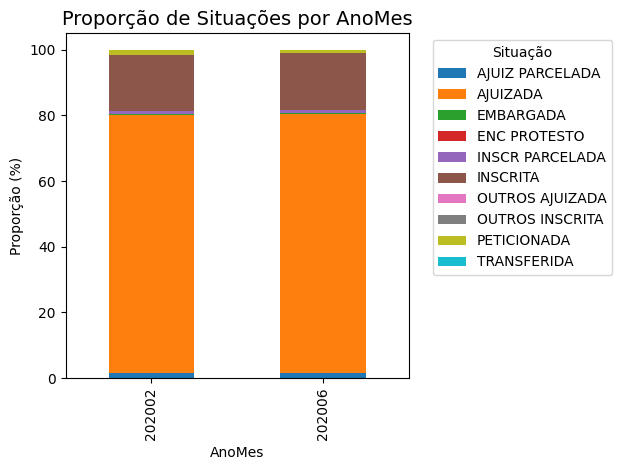

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# final_df['ANOMES'] = pd.to_datetime(final_df['ANOMES']).dt.year

# Create proportion plot
plt.figure(figsize=(20, 10))

# Calculate proportions
props = (final_df.groupby(['ANOMES', 'SITUACAO_INSCRICAO'])
         .size()
         .unstack()
         .fillna(0)
         .apply(lambda x: x/x.sum() * 100, axis=1))

# Create stacked bar plot
ax = props.plot(kind='bar', stacked=True)

plt.title('Proporção de Situações por AnoMes', fontsize=14)
plt.xlabel('AnoMes')
plt.ylabel('Proporção (%)')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend outside of plot
plt.legend(title='Situação', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

<Figure size 2000x1000 with 0 Axes>

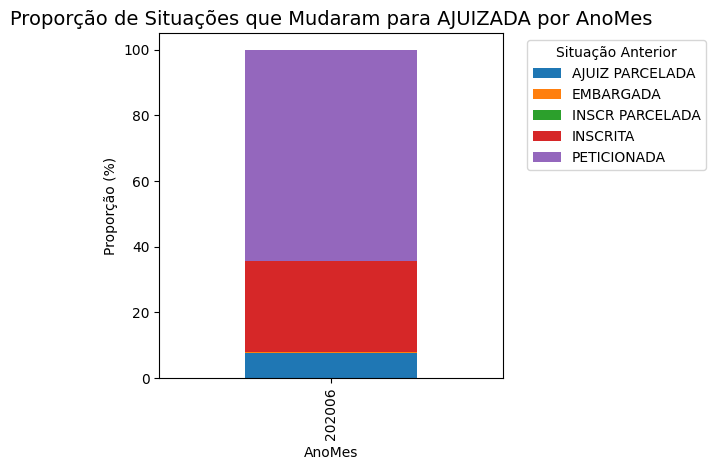

In [ ]:
mudou_para_ajuizada = situacao_df[situacao_df['MUDOU_PARA_AJUIZADA'] == True]
plt.figure(figsize=(20, 10))
props = (mudou_para_ajuizada.groupby(['ANOMES', 'SITUACAO_INSCRICAO_ANTERIOR'])
         .size()
         .unstack()
         .fillna(0)
         .apply(lambda x: x/x.sum() * 100, axis=1))

ax = props.plot(kind='bar', stacked=True)

plt.title('Proporção de Situações que Mudaram para AJUIZADA por AnoMes', fontsize=14)
plt.xlabel('AnoMes')
plt.ylabel('Proporção (%)')

plt.xticks(rotation=90)
plt.legend(title='Situação Anterior', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

In [85]:
#ver situacao distinta
unique_situacao = final_df[[
    'SITUACAO_INSCRICAO'
]].drop_duplicates()

unique_situacao

,SITUACAO_INSCRICAO
0,INSCRITA
1,AJUIZADA
90,INSCR PARCELADA
219,PETICIONADA
232,AJUIZ PARCELADA
1949,TRANSFERIDA
3124,EMBARGADA
7302,OUTROS INSCRITA
10425,OUTROS AJUIZADA
78833,ENC PROTESTO


In [86]:
# Get counts and proportions of each situation grouped by ANOMES
summary_by_anomes = []

for anomes in final_df['ANOMES'].unique():
    df_anomes = final_df[final_df['ANOMES'] == anomes]
    
    situacao_counts = df_anomes['SITUACAO_INSCRICAO'].value_counts()
    situacao_props = (situacao_counts / len(df_anomes) * 100).round(2)
    
    summary_df = pd.DataFrame({
        'ANOMES': anomes,
        'Count': situacao_counts,
        'Percentage': situacao_props
    })
    
    summary_by_anomes.append(summary_df)

# Combine all summaries
final_summary = pd.concat(summary_by_anomes)
final_summary = final_summary.reset_index()
final_summary = final_summary.pivot(index='SITUACAO_INSCRICAO', 
                                  columns='ANOMES', 
                                  values=['Count', 'Percentage'])

# Display the results
print("\nCounts by ANOMES:")
print(final_summary['Count'])
print("\nPercentages by ANOMES:")
print(final_summary['Percentage'])


Counts by ANOMES:
ANOMES                202002    202006
SITUACAO_INSCRICAO                    
AJUIZ PARCELADA       7509.0    7475.0
AJUIZADA            346411.0  347505.0
EMBARGADA              882.0     875.0
ENC PROTESTO             3.0       2.0
INSCR PARCELADA       3749.0    3736.0
INSCRITA             75581.0   76929.0
OUTROS AJUIZADA         70.0      70.0
OUTROS INSCRITA         73.0      73.0
PETICIONADA           7016.0    4208.0
TRANSFERIDA             16.0      15.0

Percentages by ANOMES:
ANOMES              202002  202006
SITUACAO_INSCRICAO                
AJUIZ PARCELADA       1.70    1.70
AJUIZADA             78.50   78.82
EMBARGADA             0.20    0.20
ENC PROTESTO          0.00    0.00
INSCR PARCELADA       0.85    0.85
INSCRITA             17.13   17.45
OUTROS AJUIZADA       0.02    0.02
OUTROS INSCRITA       0.02    0.02
PETICIONADA           1.59    0.95
TRANSFERIDA           0.00    0.00


In [21]:
# Ver todas as mudanças possíveis de situação
mudancas_possiveis = (
    situacao_df[['SITUACAO_INSCRICAO_ANTERIOR', 'SITUACAO_INSCRICAO']]
    .drop_duplicates()
    .reset_index(drop=True)
)

mudancas_possiveis

,SITUACAO_INSCRICAO_ANTERIOR,SITUACAO_INSCRICAO
0,NaN,AJUIZADA
1,AJUIZADA,AJUIZADA
2,NaN,INSCRITA
3,INSCRITA,INSCRITA
4,NaN,PETICIONADA
5,PETICIONADA,PETICIONADA
6,PETICIONADA,AJUIZADA
7,INSCRITA,AJUIZADA
8,INSCRITA,PETICIONADA
9,PETICIONADA,INSCRITA


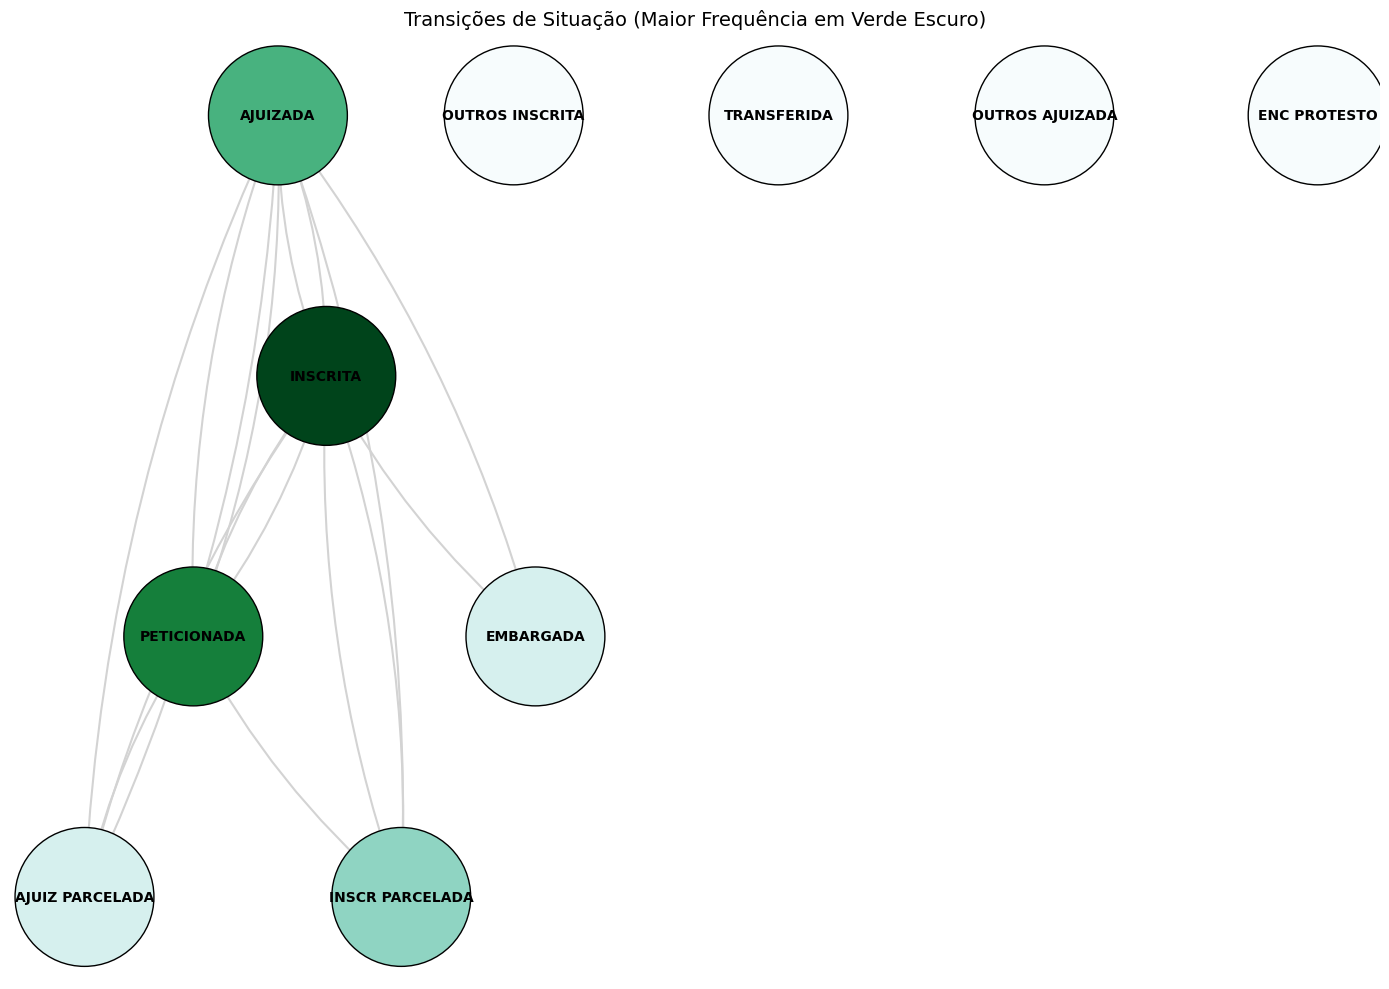

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

# Criar grafo
graph = nx.DiGraph()

# Contar transições
transicoes = Counter()
for _, row in mudancas_possiveis.iterrows():
    if pd.notna(row['SITUACAO_INSCRICAO_ANTERIOR']) and pd.notna(row['SITUACAO_INSCRICAO']):
        origem = row['SITUACAO_INSCRICAO_ANTERIOR']
        destino = row['SITUACAO_INSCRICAO']
        transicoes[(origem, destino)] += 1

# Aresta mais frequente
transicao_top = max(transicoes, key=transicoes.get)

# Adiciona as arestas ao grafo
for (origem, destino), peso in transicoes.items():
    graph.add_edge(origem, destino, weight=peso)

# Layout
pos = graphviz_layout(graph, prog='dot')

# Cores dos nós
out_degrees = dict(graph.out_degree())
node_colors = [out_degrees[node] for node in graph.nodes]

# Preparar dados das arestas
edge_colors = []
edge_widths = []
edge_arrows = []

for u, v in graph.edges():
    if (u, v) == transicao_top:
        edge_colors.append('darkgreen')   # Destaque máximo
        edge_widths.append(4.5)
        edge_arrows.append(35)
    elif graph[u][v]['weight'] >= 10:
        edge_colors.append('crimson')     # Destaque intermediário
        edge_widths.append(2.5)
        edge_arrows.append(25)
    else:
        edge_colors.append('lightgray')   # Transições comuns
        edge_widths.append(1.5)
        edge_arrows.append(20)

plt.figure(figsize=(14, 10))

# Nós
nx.draw_networkx_nodes(
    graph, pos,
    node_size=10000,
    node_color=node_colors,
    cmap=plt.cm.BuGn,
    edgecolors='black',
    linewidths=1
)

# Desenhar arestas com personalização individual
for i, (u, v) in enumerate(graph.edges()):
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v)],
        arrowstyle='-|>',
        arrowsize=edge_arrows[i],
        width=edge_widths[i],
        edge_color=edge_colors[i],
        connectionstyle='arc3,rad=0.1'
    )

# Rótulos dos nós
nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")

plt.title("Transições de Situação (Maior Frequência em Verde Escuro)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random  # Importa a biblioteca random

# ======= CONFIGURAÇÕES =======
limite_transicoes = 1  # Mostra apenas transições com pelo menos esse número
usar_grupos = True     # Define se os nós devem ser coloridos por grupo

# EXEMPLO: Supondo que você tenha um DataFrame com colunas:
# 'SITUACAO_INSCRICAO_ANTERIOR', 'SITUACAO_INSCRICAO', 'GRUPO_SITUACAO' (opcional)
# Se não tiver grupo, criaremos um por padrão
if 'GRUPO_SITUACAO' not in mudancas_possiveis.columns:
    mudancas_possiveis['GRUPO_SITUACAO'] = mudancas_possiveis['SITUACAO_INSCRICAO']

# Criar grafo
G = nx.DiGraph()
transicoes = Counter()

for _, row in mudancas_possiveis.iterrows():
    origem = row['SITUACAO_INSCRICAO_ANTERIOR']
    destino = row['SITUACAO_INSCRICAO']
    if pd.notna(origem) and pd.notna(destino):
        transicoes[(origem, destino)] += 1

# Adicionar arestas com pesos acima do limite
for (origem, destino), peso in transicoes.items():
    if peso >= limite_transicoes:
        G.add_edge(origem, destino, weight=peso)

# Verifica quais nós ainda estão presentes
nos_validos = set(G.nodes())

# Criar dicionário de grupos
grupos_dict = mudancas_possiveis.set_index('SITUACAO_INSCRICAO')['GRUPO_SITUACAO'].to_dict()
grupos_nos = {n: grupos_dict.get(n, 'Desconhecido') for n in G.nodes()}

# Codificar cores por grupo
grupos_unicos = sorted(set(grupos_nos.values()))
cmap = cm.get_cmap('tab10', len(grupos_unicos))
cores_grupo = {grupo: mcolors.to_hex(cmap(i)) for i, grupo in enumerate(grupos_unicos)}

# Layout com Graphviz para hierarquia (prog='dot' já é adequado para isso)
pos = graphviz_layout(G, prog='dot')

# Criar nós
node_x, node_y, node_text, node_colors = [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(-y)
    node_text.append(f"{node}<br>Grupo: {grupos_nos[node]}")
    node_colors.append(cores_grupo[grupos_nos[node]])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='bottom center',
    hoverinfo='text',
    marker=dict(
        color=node_colors,
        size=100,  # Aumenta o tamanho do nó (bola)
        line=dict(color='black', width=2)
    )
)

# Criar arestas
edge_traces = []
annotations = []

# Determina a transição mais frequente
transicao_top = max(transicoes.items(), key=lambda x: x[1] if x[0] in G.edges else -1)[0]

for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    y0, y1 = -y0, -y1
    peso = G[u][v]['weight']

    # Cor da seta baseada no nó de origem
    cor_origem = cores_grupo[grupos_nos[u]]  # Cor do nó de origem (u)
    width = 1.5  # Define a espessura da seta

    # Afastar as setas para fora dos nós com offset aleatório
    offset = random.uniform(1, 5)  # Gera um valor aleatório entre 1 e 5

    # Nova posição para as setas
    x0 += offset
    y0 += offset
    x1 += offset
    y1 += offset

    # Adiciona arestas com a cor correspondente ao nó de origem
    edge_traces.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(color=cor_origem, width=width),
        hoverinfo='text',
        text=[f"{u} → {v}<br>Transições: {peso}"]
    ))

    # Adiciona setas fora dos nós, com a cor do nó de origem
    annotations.append(dict(
        ax=x0, ay=y0,
        x=x1, y=y1,
        xref='x', yref='y',
        axref='x', ayref='y',
        showarrow=True,
        arrowhead=2,    # Tamanho da ponta da seta
        arrowsize=2,    # Aumenta o tamanho da seta
        arrowwidth=2,   # Aumenta a largura da seta
        arrowcolor=cor_origem,  # Cor da seta igual ao nó de origem
        opacity=0.8
    ))

# Layout do gráfico
fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title=dict(text=f'Transições de Situação (≥ {limite_transicoes} ocorrências)', font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        annotations=annotations
    )
)

# Salvar o gráfico como arquivo HTML
fig.write_html("grafo_interativo.html")


/tmp/ipykernel_296769/1365916510.py:44: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



## Preparação dos Dados (Data Preparation)

`Transformação dos dados brutos em um conjunto limpo e estruturado, adequado para modelagem. Inclui limpeza, seleção de atributos, engenharia de variáveis etc.`

## Modelagem (Modeling)

`Aplicação de algoritmos de aprendizado de máquina ou estatísticos nos dados preparados. Envolve escolha de modelos, parametrização e validação.`

Árvores de Decisão ou Random Forest: Modelos robustos para problemas de classificação, que podem lidar bem com variáveis categóricas e numéricas.

Regressão Logística: Um modelo simples que pode ser útil para previsões binárias, como se a dívida será ajuizada ou não.

XGBoost: Um modelo de árvore de decisão mais avançado, frequentemente usado para classificações de alta performance.

## Avaliação (Evaluation)

`Verificação se o modelo atende aos objetivos definidos na fase de entendimento do negócio. Pode incluir`métricas quantitativas e feedback qualitativo.`

## Implantação (Deployment)

`Colocação do modelo em uso no ambiente real. Pode ser um relatório, uma aplicação interativa ou uma integração em sistema.`